# Imports

In [120]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Point
from pysal.lib import weights
from pysal.explore import esda
import seaborn
from esda.moran import Moran_Local
from splot import esda as esdaplot
import time
import seaborn as sns

In [121]:
# Data loading
gdp_df = pd.read_csv("data/GDP(Nuts2)/nama_10r_2gdp_linear.csv")
# Choosing a unit - PPS (Purchasing Power Standards) per inhabitant
gdp_df = gdp_df[gdp_df['unit']=='PPS_EU27_2020_HAB']
# Renaming geo column
gdp_df.rename(columns={'geo': 'NUTS_ID'}, inplace=True)
gdp_df.rename(columns={'OBS_VALUE': 'GDP_VALUE'}, inplace=True)
# Removing unnecessary columns (only one value for all rows)
gdp_df = gdp_df.drop(columns=['DATAFLOW','LAST UPDATE','freq', 'unit', 'OBS_FLAG'])
# Convert all values to a specific type (e.g., int)
gdp_df['NUTS_ID'] = gdp_df['NUTS_ID'].astype(object)
gdp_df['TIME_PERIOD'] = gdp_df['TIME_PERIOD'].astype(str)
gdp_df['GDP_VALUE'] = gdp_df['GDP_VALUE'].astype(float)

# Reading the shapefile data (ESPG:3035 - projected CRS needed for centroid calculation!)
gdf_3035 = gpd.read_file("data/NUTS_RG_20M_2021_3035.shp/NUTS_RG_20M_2021_3035.shp")
# Reading the shapefile data (ESPG:4326 - GEOGRAPHIC COORDINATE SYSTEM)
gdf_4326 = gpd.read_file("data/NUTS_RG_20M_2021_4326.shp/NUTS_RG_20M_2021_4326.shp")
# Merging gdp_2021 data with shapefile data
merged_df = pd.merge(gdp_df, gdf_3035, on='NUTS_ID', how='left')
# Extracting ONLY nuts level 2 regions!
gdp_lvl2_df = merged_df[merged_df['LEVL_CODE']== 2.0]
# Selecting only the required columns
gdp_lvl2 = gdp_lvl2_df[['NUTS_ID', 'NUTS_NAME', 'NAME_LATN', 'GDP_VALUE', 'TIME_PERIOD', 'geometry']].copy()
# Create a GeoDataFrame
gdp_lvl2 = gpd.GeoDataFrame(gdp_lvl2, geometry='geometry')

##-----Centroid Calculation-------##
# Now, calculate the centroids (but float values!)
gdp_lvl2['centroid_lon'] = gdp_lvl2.geometry.centroid.x
gdp_lvl2['centroid_lat'] = gdp_lvl2.geometry.centroid.y
# Create a new geometry column for the centroids
gdp_lvl2['centroid_geometry'] = gdp_lvl2.apply(lambda row: Point(row['centroid_lon'], row['centroid_lat']), axis=1)
# Convert the DataFrame to a GeoDataFrame with the new geometry column
gdf_lvl2 = gpd.GeoDataFrame(gdp_lvl2, geometry='geometry')
# Converting geo df into coordinate system (only for visualizations!)
gdf_lvl2.crs = "EPSG:3035"
gdf_vis = gdf_lvl2.to_crs(epsg=4326)

## Time series preparation

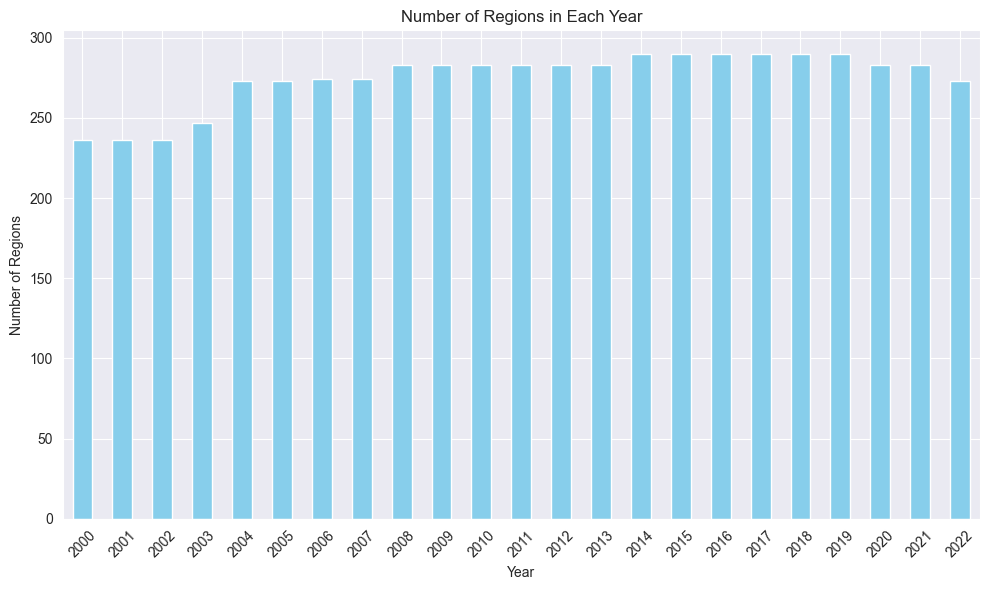

In [122]:
# Count the number of regions for each year
regions_per_year = gdf_lvl2.groupby('TIME_PERIOD')['NUTS_ID'].nunique()

# Create the bar chart
plt.figure(figsize=(10, 6))
regions_per_year.plot(kind='bar', color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Regions')
plt.title('Number of Regions in Each Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [123]:
# Convert 'TIME_PERIOD' column to numeric if it's stored as strings
gdf_lvl2['TIME_PERIOD'] = pd.to_numeric(gdf_lvl2['TIME_PERIOD'])
# Filter the DataFrame to include only rows from 2004 to 2021
filtered_gdf = gdf_lvl2[gdf_lvl2['TIME_PERIOD']==2004]
nuts_regions = list(filtered_gdf['NUTS_ID'])
# Filter the DataFrame to include only rows from 2004 to 2021
filtered_gdf_lvl2 = gdf_lvl2[(gdf_lvl2['TIME_PERIOD'] >= 2004) & (gdf_lvl2['TIME_PERIOD'] <= 2021)]
# Filter the DataFrame to include only the regions from the list
final_df = filtered_gdf_lvl2[filtered_gdf_lvl2['NUTS_ID'].isin(nuts_regions)]

In [124]:
def year_df_creation(final_df, year):
    "Create a dataframe of the respective years to act as time series in SAC calculation"
    time_df = final_df[final_df['TIME_PERIOD']==year]
    return time_df

In [125]:
def region_df_creation(final_df, region):
    "Create a dataframe of the respective regions to act as time series in SAC calculation"
    region_df = final_df[final_df['NUTS_ID']==region]
    return region_df

## Spatial Weights Creation

In [126]:
# Making sure that each region has data for each year from 2004 to 2021 (equal length of time series!)
# Define the list of required years
required_years = set(range(2004, 2022))
# Find NUTS_IDs with complete years
def has_all_years(group):
    return required_years.issubset(group['TIME_PERIOD'].unique())
# Filter NUTS_IDs
valid_nuts_ids = final_df.groupby('NUTS_ID').filter(has_all_years)['NUTS_ID'].unique()
# Convert to list if needed
valid_nuts_ids_list = valid_nuts_ids.tolist()
final_df = final_df[final_df['NUTS_ID'].isin(valid_nuts_ids_list)]

In [127]:
## Extract only for one year to calculate spatial weight (preventing repeated regions)!!
region_df = year_df_creation(final_df, 2004)

## Making sure that the index of region is NUTS_ID
# Setting the index to NUTS_ID
region_df.set_index('NUTS_ID', inplace=True)

## Creating spatial weights
region_df = region_df.set_geometry('geometry')

# Building kernel weights
# Distance weights: Build weights with adaptive bandwidth
w_adaptive = weights.distance.Kernel.from_dataframe(region_df, fixed=False, k=15)
# Distance weights: Generate W from the GeoDataFrame
w_KNN= weights.KNN.from_dataframe(region_df, k=8)

# Row-standardization
w_KNN.transform = "R"
w_adaptive.transform = "R"

### Accessing weights between each region pair

In [11]:
neighbor_weights_dict = {}
for region_id, neighbors in w_adaptive.neighbors.items():
    weights_for_region = [w_adaptive[region_id][neighbor_id] for neighbor_id in neighbors]
    neighbor_weights_dict[region_id] = {neighbor_id: weight for neighbor_id, weight in zip(neighbors, weights_for_region)}

# Note: the dictionary only considers 15 neighbors that satisfy each region's adaptive bandwidth (so remaining regions
# (are assigned weights of ZERO which is implied)!
len(neighbor_weights_dict)

273

# Deviation of Time Series

In [12]:
def corr_time_series(X_T,Y_T):
    """Calculate the correlation between time series data of pairs of locations"""
    # Convert data frame columns to numpy arrays
    X_T = X_T.values
    Y_T = Y_T.values
    # Compute the difference between consecutive elements in the time series
    diff_X = X_T[1:] - X_T[:-1]
    diff_Y = Y_T[1:] - Y_T[:-1]
    # Compute the product of the differences
    product_diff = diff_X * diff_Y
    # Sum the products from t to T-1
    sum_product = np.sum(product_diff)

    # Square the differences
    squared_diff_X = diff_X ** 2
    squared_diff_Y = diff_Y ** 2
    # Compute the square root of the squared differences
    sqrt_squared_diff_X = np.sqrt(squared_diff_X)
    sqrt_squared_diff_Y = np.sqrt(squared_diff_Y)
    # Compute the product of the square roots
    product_sqrt = sqrt_squared_diff_X * sqrt_squared_diff_Y
    # Sum the products from t to T-1
    sum_product_sqrt = np.sum(product_sqrt)

    # Calculate the correlation between the time series
    # Check if sum_product_sqrt is zero
    if sum_product_sqrt != 0:
        corr_value = sum_product / sum_product_sqrt
    else:
        corr_value = "undefined"
    return corr_value

In [13]:
def deviation_time_series(corr_value, X_T, Y_T):
    """Calculate the deviation between time series from correlation value calculated before"""
    # Calculate sum of X_T and Y_T
    vol_X_T = np.sum(X_T)
    vol_Y_T = np.sum(Y_T)
    # Define the adaptive tuning function
    if corr_value != "undefined":
        tuned_corr_value = 2 / (1 + np.exp(2 * corr_value))
    else:
        tuned_corr_value = "undefined"

    # Calculate deviation between time series
    if tuned_corr_value != "undefined":
        deviation_value = tuned_corr_value * (vol_X_T - vol_Y_T)
    else:
        deviation_value = "undefined"
    return deviation_value

In [14]:
def adjusted_time_series(corr_value, X_T):
    """Calculate the time series of each region adjusted for via correlation between time series and the mean series"""
    # Calculate sum of X_T
    vol_X_T = np.sum(X_T)
    # Define the adaptive tuning function
    if corr_value != "undefined":
        tuned_corr_value = 2 / (1 + np.exp(2 * corr_value))
    else:
        tuned_corr_value = "undefined"

    # Calculate deviation between time series
    if tuned_corr_value != "undefined":
        adjusted_value = tuned_corr_value * vol_X_T
    else:
        adjusted_value = "undefined"
    return adjusted_value

# Adjusted and Mean time series columns

# Spatiotemporal Autocorrelation

Note: Since the weights are always multiplied, if two pairs of regions are assigned zero weights (aka all the regions that are not recorded as neighbors of a particular region i), then they need not be considered - only consider weights present in neighbor_weights_dict.

## Global Spatiotemporal Autocorrelation

In [56]:
# Calculate mean GDP over all regions for each year
# Group by TIME_PERIOD and calculate the mean GDP value summed over all regions for each year
mean_gdp_sum_per_year = final_df.groupby('TIME_PERIOD')['GDP_VALUE'].mean()
# Convert the resulting series to a DataFrame
mean_gdp_df = mean_gdp_sum_per_year.to_frame(name='Mean_GDP')

In [57]:
regions = list(neighbor_weights_dict.keys())
len(regions)

273

In [58]:
def global_STAC(neighbor_weights_dict, final_df, var):
    """Calculate the global spatiotemporal autocorrelation value"""
    # Initializing variables
    spatial_w_sum = 0.0
    numerator = 0.0
    denominator = 0.0
    # Calculate sum of all spatial weights
    # Iterate over all regions
    for region, neighbor_weights in neighbor_weights_dict.items():
    # Iterate over all neighbor weights for the current region
        for weight in neighbor_weights.values():
            # Add the weight to the total sum
            spatial_w_sum += weight
    # Calculate total number of regions
    N = len(region_df)
    first_term = N / spatial_w_sum

    for region_i, neighbor_weights in neighbor_weights_dict.items():
        # Iterate over all neighbor weights for the current region
        time_series_i = region_df_creation(final_df, region_i)
        corr_i = corr_time_series(time_series_i[var], mean_gdp_df['Mean_GDP'])
        # counter variable for neighbors' indices
        count = 0
        for weight in neighbor_weights.values():
            neighbor_regions= list(neighbor_weights)
            region_j = neighbor_regions[count]
            time_series_j = region_df_creation(final_df, region_j)
            corr_j = corr_time_series(time_series_j[var], mean_gdp_df['Mean_GDP'])
            numerator += (weight * deviation_time_series(corr_i, time_series_i[var], mean_gdp_df['Mean_GDP']) * deviation_time_series(corr_j, time_series_j[var], mean_gdp_df['Mean_GDP']))
            count += 1
        dev_time_series_i_squared = (deviation_time_series(corr_i, time_series_i[var], mean_gdp_df['Mean_GDP'])) ** 2
        denominator +=  dev_time_series_i_squared

    # Calculate the final global STAC
    global_STAC_val = first_term * (numerator / denominator)
    return global_STAC_val

global_STAC_val = global_STAC(neighbor_weights_dict, final_df, 'GDP_VALUE')

In [59]:
global_STAC_val

0.6207243325948555

## Local Spatiotemporal Autocorrelation

In [60]:
def local_STAC(neighbor_weights_dict, final_df):
    "Calculate the local spatiotemporal autocorrelation values for each region"
    # Initializing values
    denominator = 0.0 # to store denominator of each LISA value
    LISA_dict = dict() # to store all LISA values with its region IDs
    # Calculate total number of regions
    N = len(region_df)
    # Calculate denominator (same for each region)
    for region_i, neighbor_weights in neighbor_weights_dict.items():
        time_series_i = region_df_creation(final_df, region_i)
        corr_i = corr_time_series(time_series_i['GDP_VALUE'], mean_gdp_df['Mean_GDP'])
        dev_i = deviation_time_series(corr_i, time_series_i['GDP_VALUE'], mean_gdp_df['Mean_GDP'])
        dev_i_squared = dev_i ** 2
        denominator += dev_i_squared
    # Calculate numerator by iterating through all neighbors for each region
    for region_i, neighbor_weights in neighbor_weights_dict.items():
        time_series_i = region_df_creation(final_df, region_i)
        corr_i = corr_time_series(time_series_i['GDP_VALUE'], mean_gdp_df['Mean_GDP'])
        dev_i = deviation_time_series(corr_i, time_series_i['GDP_VALUE'], mean_gdp_df['Mean_GDP'])
        # Initialize sum
        sum_j = 0.0
        # Counter variable for neighbors' indices
        count = 0
        for weight in neighbor_weights.values():
            neighbor_regions= list(neighbor_weights)
            region_j = neighbor_regions[count]
            time_series_j = region_df_creation(final_df, region_j)
            corr_j = corr_time_series(time_series_j['GDP_VALUE'], mean_gdp_df['Mean_GDP'])
            dev_j = deviation_time_series(corr_j, time_series_j['GDP_VALUE'], mean_gdp_df['Mean_GDP'])
            sum_j += weight * dev_j
            count += 1
        numerator = N * dev_i * sum_j
        local_val = numerator / denominator
        # Storing lisa value for each region in dictionary
        LISA_dict[region_i] = local_val
    return LISA_dict

local_STAC_dict = local_STAC(neighbor_weights_dict, final_df)

In [64]:
# percentage of lisa values above 0 (positive)
lisa_list = list(local_STAC_dict.values())
count_above_zero = sum(1 for value in lisa_list if value > 0)
total_values = len(lisa_list)
percentage = (count_above_zero / total_values) * 100
percentage

83.15018315018315

### Density plot of local LISA values

Text(0.5, 1.0, 'Density Diagram of Local Moran Values')

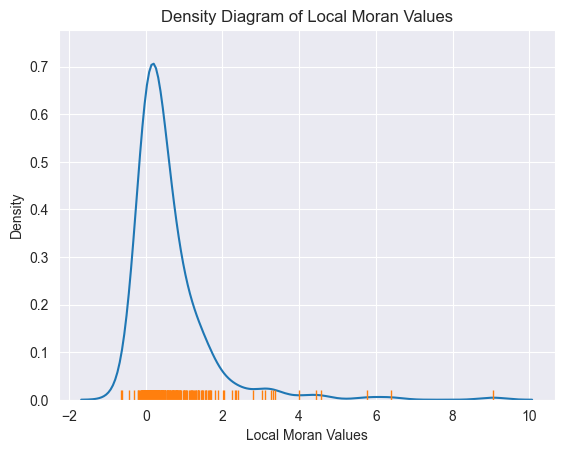

In [65]:
# Creating a numpy array of lisa values
lisa_values = np.array(list(local_STAC_dict.values()))
# Creating a density plot of Local LISA values
# Draw KDE line
ax = seaborn.kdeplot(lisa_values)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa_values, ax=ax)
# Add x-axis label
ax.set_xlabel('Local Moran Values')
# Add title
ax.set_title('Density Diagram of Local Moran Values')

### LISA Significance

In [53]:
region_df

,NUTS_NAME,NAME_LATN,GDP_VALUE,TIME_PERIOD,geometry,centroid_lon,centroid_lat,centroid_geometry
NUTS_ID,,,,,,,,
AT11,Burgenland,Burgenland,18900.0,2004,"POLYGON ((4846489.857 2803511.391, 4854633.294...",4.811632e+06,2.736034e+06,POINT (4811631.520 2736034.450)
AT12,Niederösterreich,Niederösterreich,22600.0,2004,"POLYGON ((4742889.368 2876362.725, 4783217.798...",4.748503e+06,2.811574e+06,POINT (4748502.704 2811574.162)
AT13,Wien,Wien,37100.0,2004,"POLYGON ((4810026.316 2802881.310, 4780681.630...",4.795457e+06,2.809746e+06,POINT (4795457.186 2809746.369)
AT21,Kärnten,Kärnten,23100.0,2004,"POLYGON ((4522751.261 2668742.613, 4555161.946...",4.621094e+06,2.637144e+06,POINT (4621094.219 2637143.756)
AT22,Steiermark,Steiermark,24200.0,2004,"POLYGON ((4760796.641 2734593.840, 4780029.485...",4.699839e+06,2.696606e+06,POINT (4699839.429 2696605.859)
...,...,...,...,...,...,...,...,...
TRB1,"Malatya, Elazığ, Bingöl, Tunceli","Malatya, Elazığ, Bingöl, Tunceli",4900.0,2004,"POLYGON ((6874779.807 2348344.184, 6890718.965...",6.810685e+06,2.236288e+06,POINT (6810684.626 2236287.853)
TRB2,"Van, Muş, Bitlis, Hakkari","Van, Muş, Bitlis, Hakkari",3200.0,2004,"POLYGON ((7079743.967 2368049.187, 7090192.978...",7.131402e+06,2.329574e+06,POINT (7131401.745 2329574.128)
TRC1,"Gaziantep, Adıyaman, Kilis","Gaziantep, Adıyaman, Kilis",5200.0,2004,"POLYGON ((6820569.117 2163902.580, 6827627.296...",6.739547e+06,2.038815e+06,POINT (6739547.084 2038815.374)


In [66]:
# Initialize Moran_Local with random values to create the object
random_variable = np.random.random(len(region_df))
lisa = Moran_Local(random_variable, w_adaptive)

# Manually set the `Is` attribute to your precomputed LISA values!
lisa.Is = lisa_values

# Recalculate significance values
# Use Moran_Local and permutation function to calculate p-values!
lisa = Moran_Local(lisa_values, w_adaptive, permutations=999)

In [48]:
# Creating a lisa object using manually calculated LISA values
# lisa = Moran_Local(lisa_values, w_adaptive)

In [67]:
# resetting gdf_index before storing new columns
region_df.reset_index(inplace=True)

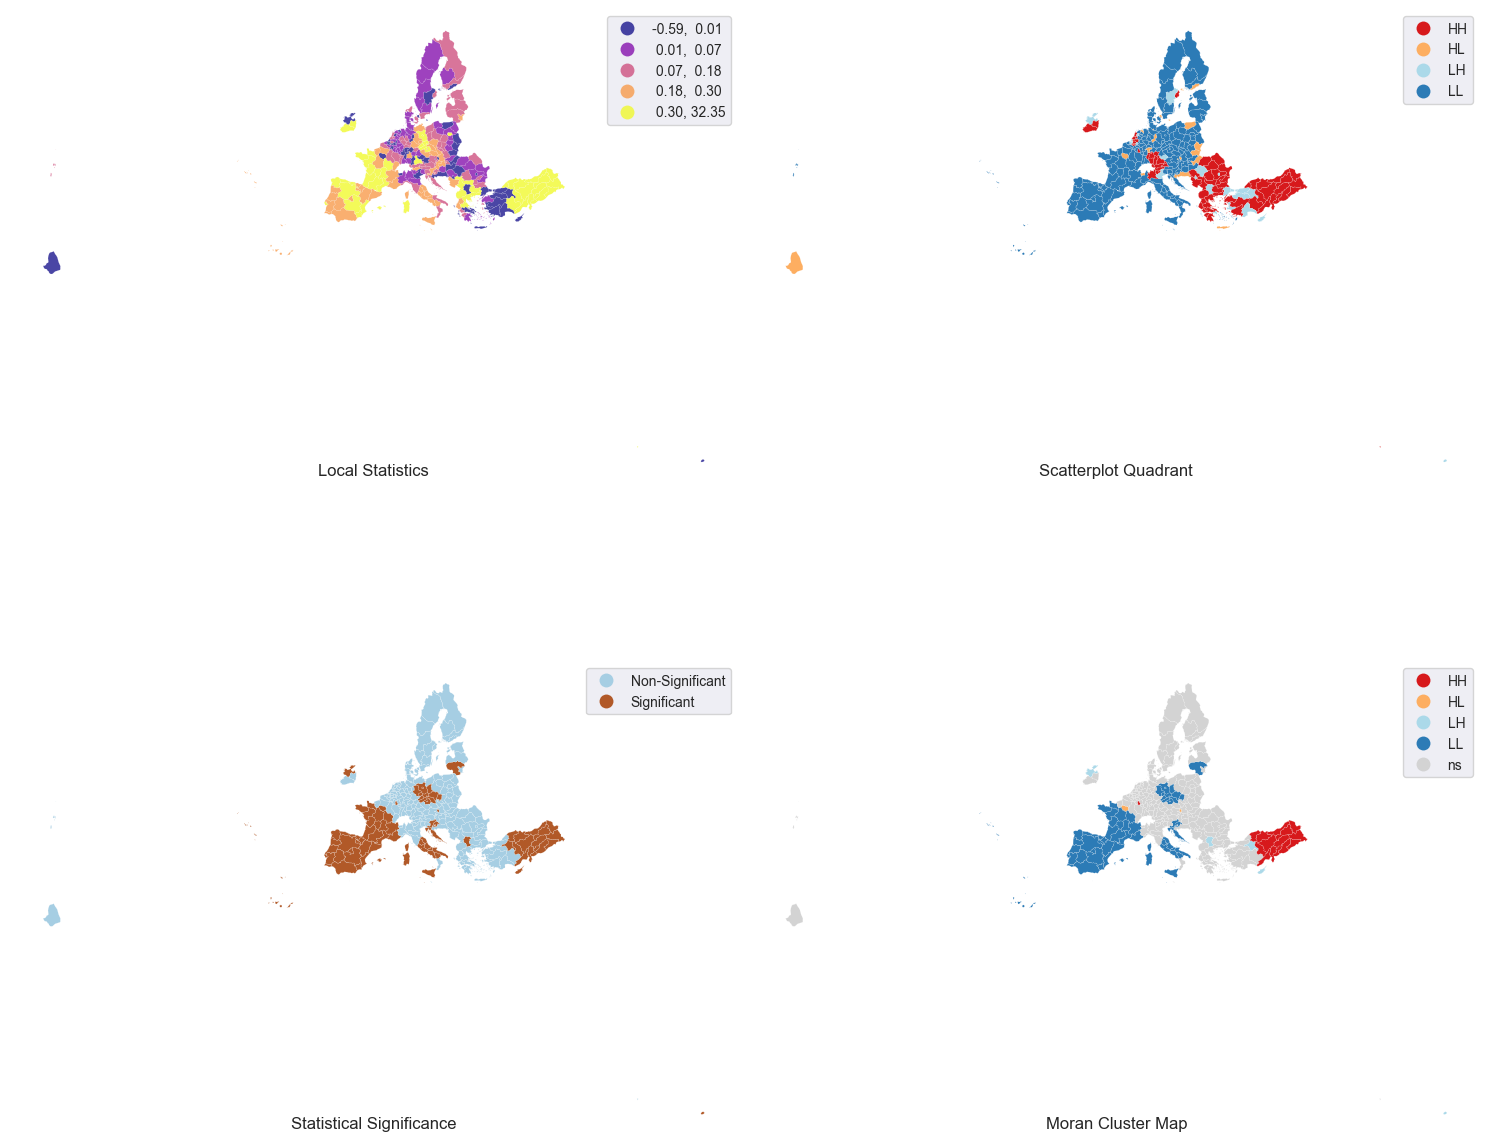

In [68]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
region_df.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, region_df, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=region_df.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
region_df.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)

# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, region_df, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()

# Adding lisa and significance column to df
numpy_df = pd.DataFrame(lisa.Is, columns=['LISA_VALUE'])
region_df['LISA_VALUE'] = numpy_df['LISA_VALUE']
series_df = labels.to_frame(name='LISA_sig')
region_df['LISA_sig'] = series_df['LISA_sig']
# Get p-values from Local Moran's I
p_values = lisa.p_sim
# Create a DataFrame with the extracted p-values
p_values_df = pd.DataFrame(p_values, columns=['LISA_p_values'])
region_df['LISA_p_values'] = p_values_df['LISA_p_values']
# Get quadrant information from Local Moran's I
qd_df = pd.DataFrame(lisa.q, columns=['LISA_quadrant'])
region_df['LISA_quadrant'] = qd_df['LISA_quadrant']

### HL,LH,HH,LL region analysis

In [69]:
region_df = region_df.drop(columns=['GDP_VALUE'])

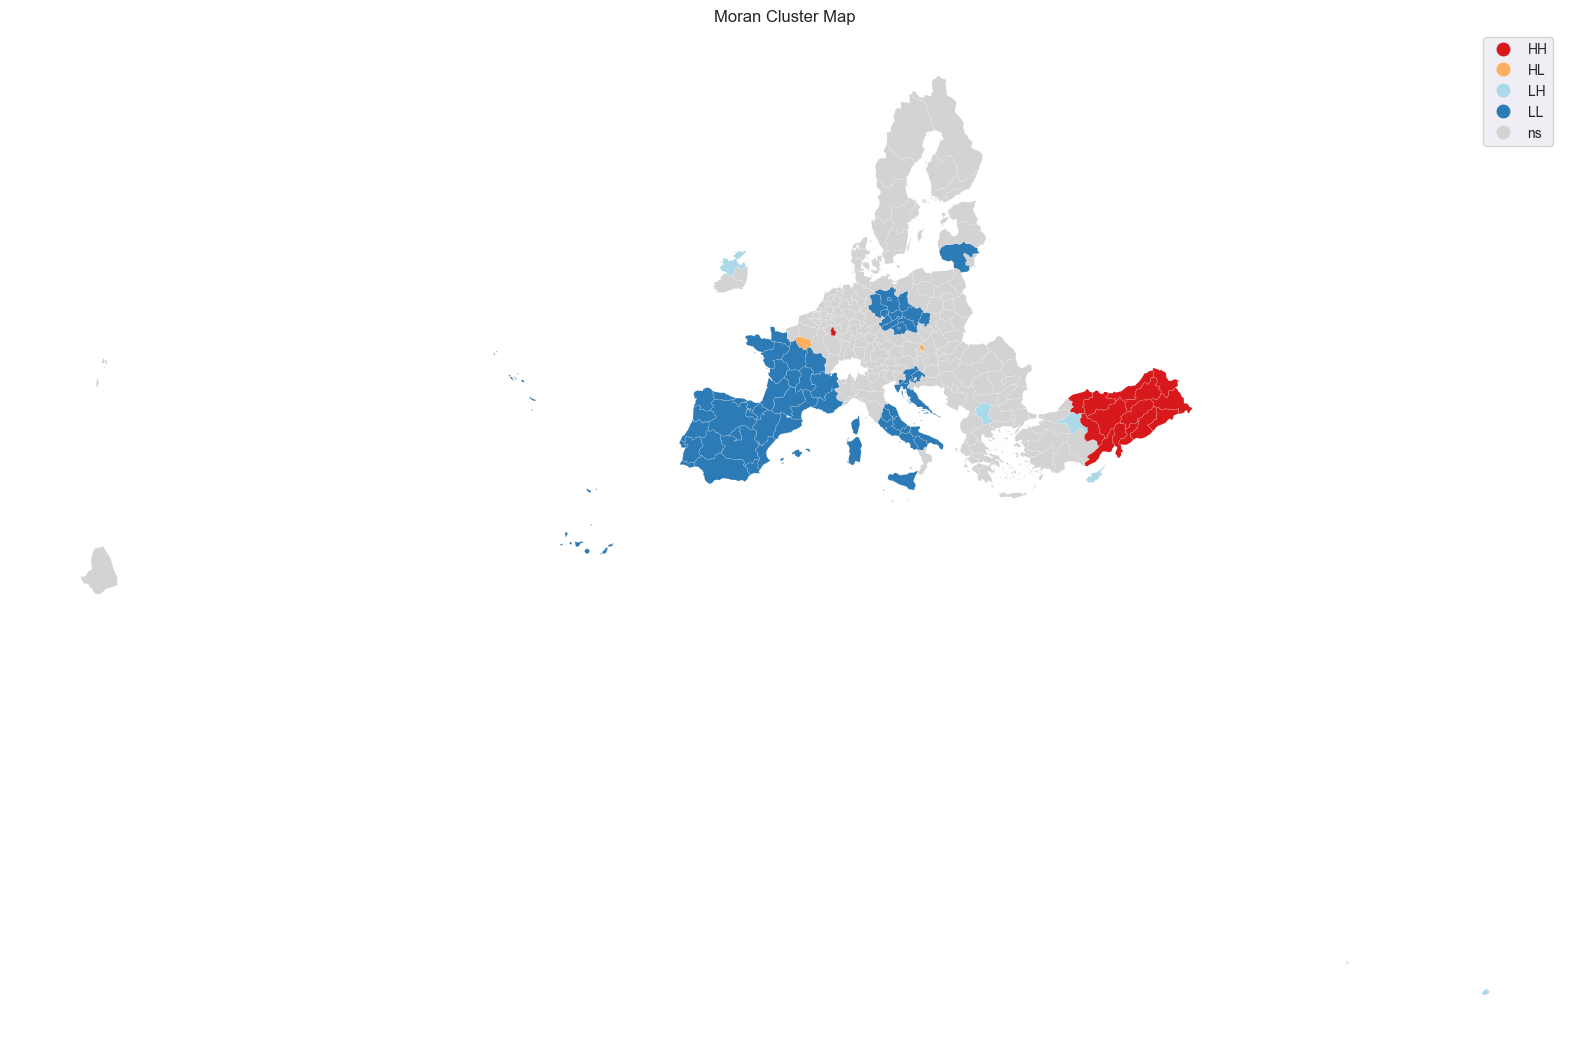

In [70]:
# Plot Quadrant colors with interactivity
fig, ax = plt.subplots(figsize=(20, 20))
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant clusters
esdaplot.lisa_cluster(lisa, region_df, p=0.05, ax=ax)
ax.set_title("Moran Cluster Map")
# Display the figure
plt.show()

Spatio-temporal autocorrelation meaning:
"The autocorrelation indicates the similarity of both the dynamic behavior (comparison of trends - temporal AC) and the accumulative magnitude of time series (spatial AC) in neighbor places".


Meaning of each Quadrant:
* High-High: HH region represents positive spatiotemporal autocorrelation: Temporal variances of GDP across the years (GDP trend over time) is similar to its neighbours.
* Low-Low: LL region represents positve spatiotemporal autocorrelation: Temporal variances of GDP across the years (GDP trend over time) is similar to its neighbours.

# HL, LH, LL and HH : CORRECT WAY!

In [31]:
# Initializing dataframes to store results in
df_region_series = pd.DataFrame(columns=['NUTS_ID', 'Region_value'])
df_mean_series = pd.DataFrame(columns=['NUTS_ID', 'Mean_value'])

# Getting list of regions
regions = list(neighbor_weights_dict.keys())
for i, region_i in enumerate(regions):
    # Iterate over all neighbor weights for the current region
    time_series_i = region_df_creation(final_df, region_i)
    corr_i = corr_time_series(time_series_i['GDP_VALUE'], mean_gdp_df['Mean_GDP'])
    region_i_val = adjusted_time_series(corr_i, time_series_i['GDP_VALUE'])
    mean_i_val = adjusted_time_series(corr_i, mean_gdp_df['Mean_GDP'])
    # Storing the results in dataframes
    df_region_series.loc[i] = [region_i, region_i_val]
    df_mean_series.loc[i] = [region_i, mean_i_val]

In [98]:
# Initializing result dataframe
quadrant_df = pd.DataFrame()

# Creating spatially lagged GDP variable
quadrant_df["NUTS_ID"] = df_region_series["NUTS_ID"]
quadrant_df["GDP"] = df_region_series["Region_value"]
quadrant_df["GDP_mean"] = df_mean_series["Mean_value"]
quadrant_df["w_GDP"] = weights.lag_spatial(w_adaptive, quadrant_df["GDP"])

# Creating respective centered versions where mean is subtracted from each
quadrant_df["GDP_std"] = quadrant_df["GDP"] - quadrant_df["GDP_mean"]
quadrant_df["w_GDP_std"] = weights.lag_spatial(w_adaptive, quadrant_df["GDP_std"])

# Calculating the quadrant information and adding new columns
for index, row in quadrant_df.iterrows():
    if row['GDP_std'] > 0.0 and row['w_GDP_std'] > 0.0:
        quadrant_df.at[index, 'Quadrant_name'] = 'HH'
        quadrant_df.at[index, 'LISA_quadrant'] = 1
    elif  row['GDP_std'] < 0.0 and row['w_GDP_std'] < 0.0:
        quadrant_df.at[index, 'Quadrant_name'] = 'LL'
        quadrant_df.at[index, 'LISA_quadrant'] = 3
    elif row['GDP_std'] < 0.0 and row['w_GDP_std'] > 0.0:
        quadrant_df.at[index, 'Quadrant_name'] = 'LH'
        quadrant_df.at[index, 'LISA_quadrant'] = 2
    else:
        quadrant_df.at[index, 'Quadrant_name'] = 'HL'
        quadrant_df.at[index, 'LISA_quadrant'] = 4

quadrant_df[quadrant_df["Quadrant_name"]=='HL']

,NUTS_ID,GDP,GDP_mean,w_GDP,GDP_std,w_GDP_std,Quadrant_name,LISA_quadrant
26,CY00,133063.795861,126057.944819,55817.162464,7005.851042,-49454.670265,HL,4.0
27,CZ01,221890.761265,102400.974963,78790.958606,119489.786302,-9762.501677,HL,4.0
46,DE30,137962.507933,103043.049041,79212.154549,34919.458892,-5722.289806,HL,4.0
79,EL30,226374.330962,195261.611132,118145.443363,31112.719831,-46992.175127,HL,4.0
99,ES30,157887.129499,111113.054810,88670.637070,46774.074689,-2783.094893,HL,4.0
116,FR10,202597.286269,102243.970337,82101.412250,100353.315932,-379.582455,HL,4.0
145,HR05,131227.392397,103150.407035,72585.944414,28076.985362,-18584.512185,HL,4.0
147,HU11,168101.654481,105214.462807,77190.668720,62887.191673,-19781.638718,HL,4.0
178,ITI4,162640.759728,117051.455257,91592.526514,45589.304472,-2313.224773,HL,4.0
179,LT01,119179.081438,102243.970337,64240.589096,16935.111101,-28049.184680,HL,4.0


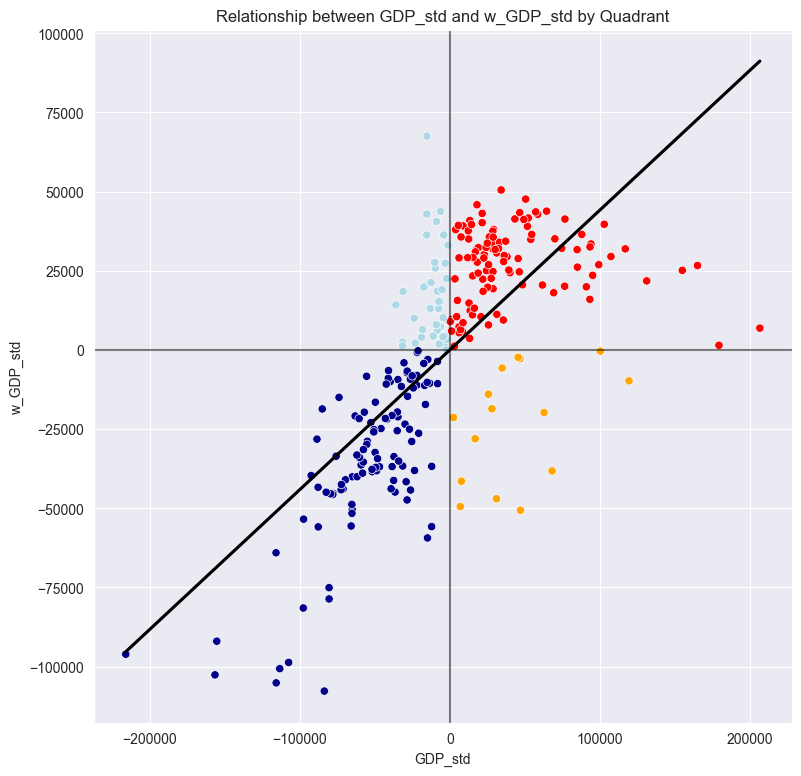

In [112]:
variable = 'GDP'
# Define the color mapping for each quadrant
color_mapping = {1: 'red', 2: 'lightblue', 3: 'darkblue', 4: 'orange'}
# Set up the figure and axis
plt.figure(figsize=(9, 9))
# Plot values - scatter plot
sns.scatterplot(
    x=variable + "_std",
    y="w_" + variable + "_std",
    data=quadrant_df,
    hue='LISA_quadrant',  # Use 'LISA_quadrant' for coloring
    palette=color_mapping,  # Apply the custom color mapping
    legend=False  # Disable the legend for simplicity
)
# Add the regression line using sns.regplot without the confidence interval
sns.regplot(
    x=variable + "_std",
    y="w_" + variable + "_std",
    data=quadrant_df,
    scatter=False,  # Disable scatter plot from regplot
    color='black',  # Regression line color
    ci=None  # Remove the error bars
)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Set axis labels
plt.xlabel(f'{variable}_std')
plt.ylabel(f'w_{variable}_std')
# Add a title
plt.title(f'Relationship between {variable}_std and w_{variable}_std by Quadrant')

# Display the plot
plt.show()

In [140]:
gdf = pd.merge(region_df, quadrant_df[['NUTS_ID','LISA_quadrant', 'Quadrant_name']], on='NUTS_ID', how='left')
gdf = gdf.dropna()
gdf

,NUTS_ID,NUTS_NAME,NAME_LATN,GDP_VALUE,TIME_PERIOD,geometry,centroid_lon,centroid_lat,centroid_geometry,LISA_quadrant,Quadrant_name
0,AT11,Burgenland,Burgenland,18900.0,2004,"POLYGON ((4846489.857 2803511.391, 4854633.294...",4.811632e+06,2.736034e+06,POINT (4811631.520 2736034.450),2.0,LH
1,AT12,Niederösterreich,Niederösterreich,22600.0,2004,"POLYGON ((4742889.368 2876362.725, 4783217.798...",4.748503e+06,2.811574e+06,POINT (4748502.704 2811574.162),1.0,HH
2,AT13,Wien,Wien,37100.0,2004,"POLYGON ((4810026.316 2802881.310, 4780681.630...",4.795457e+06,2.809746e+06,POINT (4795457.186 2809746.369),1.0,HH
3,AT21,Kärnten,Kärnten,23100.0,2004,"POLYGON ((4522751.261 2668742.613, 4555161.946...",4.621094e+06,2.637144e+06,POINT (4621094.219 2637143.756),1.0,HH
4,AT22,Steiermark,Steiermark,24200.0,2004,"POLYGON ((4760796.641 2734593.840, 4780029.485...",4.699839e+06,2.696606e+06,POINT (4699839.429 2696605.859),1.0,HH
...,...,...,...,...,...,...,...,...,...,...,...
268,TRB1,"Malatya, Elazığ, Bingöl, Tunceli","Malatya, Elazığ, Bingöl, Tunceli",4900.0,2004,"POLYGON ((6874779.807 2348344.184, 6890718.965...",6.810685e+06,2.236288e+06,POINT (6810684.626 2236287.853),3.0,LL
269,TRB2,"Van, Muş, Bitlis, Hakkari","Van, Muş, Bitlis, Hakkari",3200.0,2004,"POLYGON ((7079743.967 2368049.187, 7090192.978...",7.131402e+06,2.329574e+06,POINT (7131401.745 2329574.128),3.0,LL
270,TRC1,"Gaziantep, Adıyaman, Kilis","Gaziantep, Adıyaman, Kilis",5200.0,2004,"POLYGON ((6820569.117 2163902.580, 6827627.296...",6.739547e+06,2.038815e+06,POINT (6739547.084 2038815.374),3.0,LL
271,TRC2,"Şanlıurfa, Diyarbakır","Şanlıurfa, Diyarbakır",4200.0,2004,"POLYGON ((6989716.599 2273670.524, 6982786.486...",6.883662e+06,2.122830e+06,POINT (6883662.278 2122830.246),3.0,LL


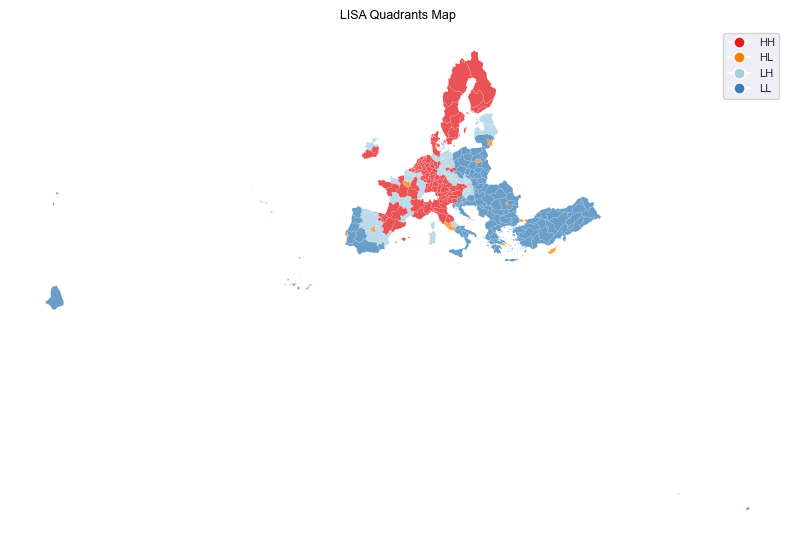

In [176]:
from matplotlib.lines import Line2D
# Define the color mapping for the LISA quadrants
color_mapping = {
    'HH': '#e41a1c',  # red
    'HL': '#ff7f00',  # orange
    'LH': '#a6cee3',  # blue
    'LL': '#377eb8'   # light blue
}
# Map the LISA quadrants to their corresponding colors
gdf['color'] = gdf['Quadrant_name'].map(color_mapping)
# Create the plot with specified background color and border settings
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Plot the geodataframe
gdf.plot(
    ax=ax,
    color=gdf['color'],
    edgecolor="white",  # White borders
    linewidth=0.1,  # Thin lines for borders
    alpha=0.75,  # Transparency level
)
# Remove axis for a cleaner look
ax.set_axis_off()
# Create custom legend with better placement and font color
legend_labels = {
    'HH': 'HH',
    'HL': 'HL',
    'LH': 'LH',
    'LL': 'LL'
}
# Create legend handles with small circular markers
# Create custom legend handles with larger circular markers
legend_handles = [Line2D([0], [0], marker='o', color='w', label=label, markersize=8, markerfacecolor=color)
                  for label, color in color_mapping.items()]
# Add the custom legend to the plot
plt.legend(handles=legend_handles, loc='upper right',fontsize=8, frameon=True)
# Set the title with white color for better visibility on dark background
plt.title("LISA Quadrants Map", fontsize=9, color='black')
# setting title at bottom: plt.figtext(0.5, 0.02, "LISA Quadrants Map", ha="center", fontsize=9, color='black')
plt.show()

# Spatiotemporal Autocorrelation: Method 2

In [363]:
# Converting years to int type to calculate temporal weights
gdf_vis['TIME_PERIOD'] = pd.to_numeric(gdf_vis['TIME_PERIOD'], errors='coerce')

## Spatial & Temporal weights

In [344]:
import math
# Using haversine distance instead of euclidean distance to take into account the curvature of the earth!
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers

    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Difference in latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c

    return distance

In [364]:
# Initialize an empty DataFrame to store spatial weights
gdf_vis.reset_index(drop=True, inplace=True)
spatial_weights_df = pd.DataFrame(index=gdf_vis.index, columns=gdf_vis.index)
temporal_weights_df = pd.DataFrame(index=gdf_vis.index, columns=gdf_vis.index)

# Iterate through each pair of rows
for i in gdf_vis.index:
    for j in gdf_vis.index:
        ## Spatial weights calculation ##
        # Calculate spatial weight between rows i and j
        point_i_lat = gdf_vis.loc[i, 'centroid_geometry'].x
        point_i_lon = gdf_vis.loc[i, 'centroid_geometry'].y
        point_j_lat = gdf_vis.loc[j, 'centroid_geometry'].x
        point_j_lon = gdf_vis.loc[j, 'centroid_geometry'].y
        # Reducing calculations when the centroids are the same!
        if point_i_lat == point_j_lat and point_i_lon == point_j_lon:
            spatial_weights_df.loc[i, j] = 0.0
        else:
            distance = haversine(point_i_lat, point_i_lon, point_j_lat, point_j_lon)
            # Storing the inverse distance as the spatial weight
            spatial_weights_df.loc[i, j] = 1 / distance

        ## Temporal weights calculation ##
        # Calculate temporal weight between rows i and j
        point_i_time = gdf_vis.loc[i, 'TIME_PERIOD']
        point_j_time = gdf_vis.loc[j, 'TIME_PERIOD']
        # Reducing calculations when the years are the same!
        if point_i_time == point_j_time:
            temporal_weights_df.loc[i, j] = 0.0
        else:
            time_diff = abs(point_i_time - point_j_time)
            #  Storing the inverse temporal difference as the temporal weight
            temporal_weights_df.loc[i, j] = 1 / time_diff

In [5]:
spatial_weights_df.to_csv("data/spatial_weights.csv")
temporal_weights_df.to_csv("data/temporal_weights.csv")

NameError: name 'spatial_weights_df' is not defined

## Reading spatial and temporal weights

In [6]:
spatial_weights_df = pd.read_csv("data/spatial_weights.csv")
temporal_weights_df = pd.read_csv("data/temporal_weights.csv")

In [12]:
temporal_weights_df = temporal_weights_df.drop(columns=['Unnamed: 0'])

In [15]:
spatial_weights_df = spatial_weights_df.drop(columns=['Unnamed: 0'])

## Original Moran's I

In [60]:
## Calculating the numerator and weights sum
# Measure starting time
start_time = time.time()

# Resetting index
gdf_vis.reset_index(drop=True, inplace=True)
# Calculate mean of the attribute values
a_mean = gdf_vis['GDP_VALUE'].mean()

# Initialize result variable
numerator_n = 0.0
sum_weights_n = 0.0

# Iterate over all combinations of i and j
for i in gdf_vis.index:
    for j in gdf_vis.index:
        # Calculate the expression for each combination of i and j
        sum_weight = spatial_weights_df.iloc[i, j]
        if sum_weight != 0:
            numerator_n += sum_weight * (gdf_vis.iloc[i]['GDP_VALUE'] - a_mean) * (gdf_vis.iloc[j]['GDP_VALUE'] - a_mean)
            sum_weights_n += sum_weight

# Measure the end time
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time

In [70]:
## Calculating the denominator
# Measure starting time
start_time = time.time()
denominator_n = 0.0

# Calculate mean of the attribute values
a_mean = gdf_vis['GDP_VALUE'].mean()

for i in gdf_vis.index:
    denominator_n += ((gdf_vis.iloc[i]['GDP_VALUE'] - a_mean) ** 2)

# Final denominator value
denominator_n = denominator_n * sum_weights_n

# Measure the end time
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time

In [79]:
# number of geographic regions
n = 290
# Moran's value
moran_value_n = (n * numerator_n)/denominator_n
moran_value_n

0.007967445161067966

## Spatiotemporal Moran's I extension

In [27]:
## Calculating the numerator and weights sum
# Measure starting time
start_time = time.time()

# Resetting index
gdf_vis.reset_index(drop=True, inplace=True)
# Calculate mean of the attribute values
a_mean = gdf_vis['GDP_VALUE'].mean()

# Initialize result variable
numerator = 0.0
sum_weights = 0.0

# Iterate over all combinations of i and j
for i in gdf_vis.index:
    for j in gdf_vis.index:
        # Calculate the expression for each combination of i and j
        sum_weight = spatial_weights_df.iloc[i, j] * temporal_weights_df.iloc[i, j]
        if sum_weight != 0:
            numerator += sum_weight * (gdf_vis.iloc[i]['GDP_VALUE'] - a_mean) * (gdf_vis.iloc[j]['GDP_VALUE'] - a_mean)
            sum_weights += sum_weight

# Measure the end time
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time

In [71]:
## Calculating the denominator
# Measure starting time
start_time = time.time()
denominator = 0.0

# Calculate mean of the attribute values
a_mean = gdf_vis['GDP_VALUE'].mean()

for i in gdf_vis.index:
    denominator += ((gdf_vis.iloc[i]['GDP_VALUE'] - a_mean) ** 2)

# Final denominator value
denominator = denominator * sum_weights

# Measure the end time
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time

In [117]:
# Calculating Final Moran's I
# Number of geographic regions
n = len(gdf_vis)

# final value
moran_value_etx = (290 * numerator) / denominator
moran_value_etx

0.011256340596130504

In [57]:
# Creating multiplied weight df
multiply_weights_df = spatial_weights_df * temporal_weights_df
multiply_weights_df

,0,1,2,3,4,5,6,7,8,9,...,6316,6317,6318,6319,6320,6321,6322,6323,6324,6325
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000082,0.000068,0.000058,0.000051,0.000045,0.000041,0.000037,0.000034,0.000031,0.000029
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000102,0.000082,0.000068,0.000058,0.000051,0.000045,0.000041,0.000037,0.000034,0.000031
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000136,0.000102,0.000082,0.000068,0.000058,0.000051,0.000045,0.000041,0.000037,0.000034
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000204,0.000136,0.000102,0.000082,0.000068,0.000058,0.000051,0.000045,0.000041,0.000037
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000409,0.000204,0.000136,0.000102,0.000082,0.000068,0.000058,0.000051,0.000045,0.000041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6321,0.000041,0.000045,0.000051,0.000058,0.000068,0.000082,0.000102,0.000136,0.000204,0.000409,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6322,0.000037,0.000041,0.000045,0.000051,0.000058,0.000068,0.000082,0.000102,0.000136,0.000204,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6323,0.000034,0.000037,0.000041,0.000045,0.000051,0.000058,0.000068,0.000082,0.000102,0.000136,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6324,0.000031,0.000034,0.000037,0.000041,0.000045,0.000051,0.000058,0.000068,0.000082,0.000102,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Statistical Significance

In [110]:
# Expectation of Moran's I, under the normality assumption!
expectation_I = -1/(n-1)
expectation_I

-0.00015810276679841898

In [91]:
# V_0 calculation
V_0 = multiply_weights_df.values.sum()
V_0

9614.344964792555

In [102]:
# V_1 calculation
V_1 = 0.0
# Iterate over all combinations of i and j
for i in gdf_vis.index:
    for j in gdf_vis.index:
        # Get the values of v_ij and v_ji
        v_ij = multiply_weights_df.iloc[i, j]
        v_ji = multiply_weights_df.iloc[j, i]
        # Calculate the squared sum and add it to the total
        V_1 += (v_ij + v_ji) ** 2
V_1 = V_1 / 2.0
V_1

66.45114372868822

In [100]:
# V_2 calculation
V_2 = 0.0
# Calculate the sum of squared (vi_. + v._i)
for i in gdf_vis.index:
    # Sum over all values in the i-th row
    sum_of_row_i = multiply_weights_df.iloc[i, :].sum()
    # Sum over all values in the i-th column
    sum_of_column_i = multiply_weights_df.iloc[:, i].sum()
    V_2 += ((sum_of_row_i + sum_of_column_i) ** 2)
V_2

67331.22478812138

In [114]:
# Calculate the expectation of I squared
n = 290
num_exp = (n * n * V_1) - (n * V_2) + (3 * V_0 * V_0)
denom_exp = (n - 1) * (n + 1) * V_0 * V_0
expectation_I_squared = num_exp / denom_exp
expectation_I_squared

3.3879347488001466e-05

In [116]:
from math import sqrt

# Calculate the Z score
var_I = expectation_I_squared - (expectation_I ** 2)
z_score_STAC = (moran_value_etx - expectation_I) / sqrt(var_I)
z_score_STAC

1.961767300138279